# Imports

In [9]:
from mpl_toolkits.mplot3d import Axes3D
%reload_ext autoreload
# %load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.patches as mpatches
from constants import AXIS_LIMITS, LEGEND_ANCHOR, SPACE_SCALE, X_LABEL, Y_LABEL, Z_LABEL, FLAT_TEXT, \
    EDGE_TEXT, SPHERE_TEXT, NORMALS_TEXT, VECTOR_SCALE, MARKER_SIZE, FORCES_TEXT, TORQUES_TEXT, NUMBER_OF_PLOTS, TIME_STATE_TEXT, \
    FLAT_REF_VEC, EDGE_REF_VEC, SPHERE_REF_VEC, SPHERE_CENTER, NUM_OF_HIS_BINS, CUBE_POSE, newest_data_set_path

%matplotlib widget
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Tuple
import matplotlib.pyplot as plt
from utils import Vector3, COLORS_RGBA, Arrow3D, l2
import json
from data_handler import DataHandler
import os
import imageio
from math import sqrt
import seaborn as sns
import glob

# Load in Data

In [10]:
FILE_PATHS_DATA = [newest_data_set_path("cube"), newest_data_set_path("edge"), newest_data_set_path("sphere"), newest_data_set_path("stanford_bunny")]
print(FILE_PATHS_DATA)

dhs: List[DataHandler] = []

for fp in FILE_PATHS_DATA:
	print(FILE_PATHS_DATA)
	if len(fp) == 0:
		continue
	dhs.append(DataHandler(fp))

if all([fp == "" for fp in FILE_PATHS_DATA]):
	raise ValueError("Yo I got no paths")


['../data/20230327_135053.json', '../data/20230328_095744.json', '../data/20230328_102647.json', '']
['../data/20230327_135053.json', '../data/20230328_095744.json', '../data/20230328_102647.json', '']
['../data/20230327_135053.json', '../data/20230328_095744.json', '../data/20230328_102647.json', '']
['../data/20230327_135053.json', '../data/20230328_095744.json', '../data/20230328_102647.json', '']
['../data/20230327_135053.json', '../data/20230328_095744.json', '../data/20230328_102647.json', '']


# Configure and Plot Data

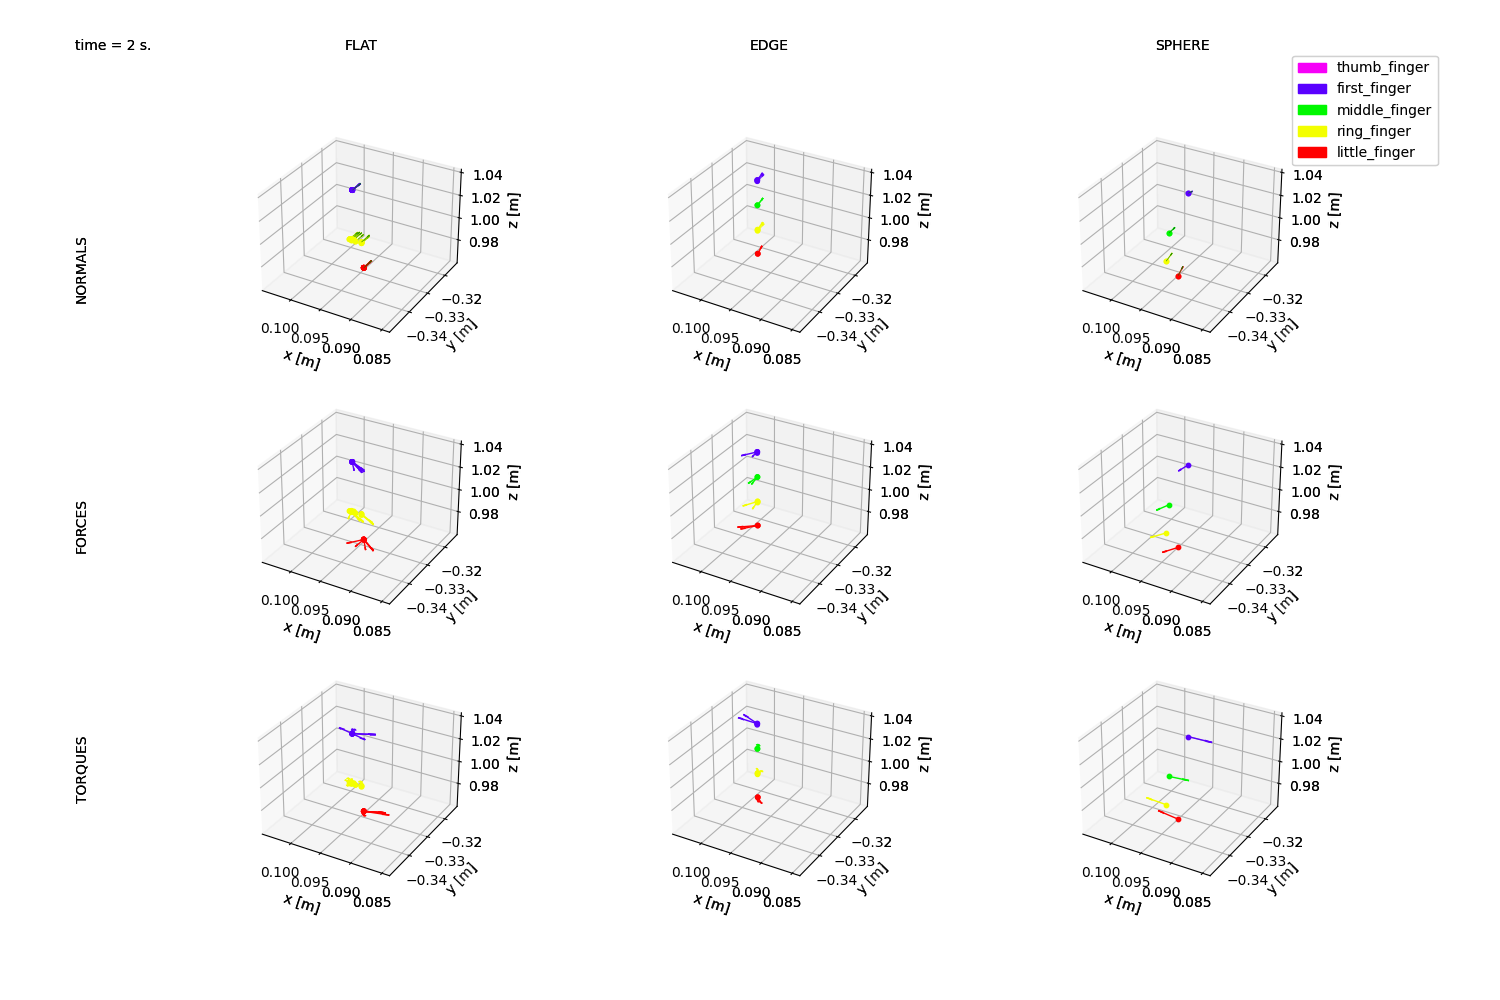

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def figure_config():
	# plt.clf()
	fig = plt.figure("Tactile Perception Data Presentation", figsize=(15, 10))
	fig.text(*FLAT_TEXT)
	fig.text(*EDGE_TEXT)
	fig.text(*SPHERE_TEXT)
	fig.text(*NORMALS_TEXT, rotation=90)
	fig.text(*FORCES_TEXT, rotation=90)
	fig.text(*TORQUES_TEXT, rotation=90)

	axes = []
	for i in range(1, NUMBER_OF_PLOTS + 1):
		ax = fig.add_subplot(330 + i, projection="3d")
		axes.append(ax)
	return fig, axes

def plot_normals(ts: DataHandler.TimeState, index: int, axes: List) -> None:
	for f in ts.fingers:
		if f.number_of_contacts == 0:
			continue
		axes[index].scatter3D(f.contact_points[0], f.contact_points[1], f.contact_points[2], color=f.color.color_code, label=f.name_verbose, alpha=1, s=MARKER_SIZE)
		for i in range(f.number_of_contacts):
			cp = Vector3(f.contact_points[0][i], f.contact_points[1][i], f.contact_points[2][i])
			n = Vector3(f.normals[0][i], f.normals[1][i], f.normals[2][i]).normalize().mul(VECTOR_SCALE)
			axes[index].quiver(cp.x, cp.y, cp.z, n.x, n.y, n.z, color=f.color.color_code, alpha=.8, lw=1)

def plot_forces(ts: DataHandler.TimeState, index: int, axes: List) -> None:
	for f in ts.fingers:
		if f.number_of_contacts == 0:
			continue
		axes[index].scatter3D(f.contact_points[0], f.contact_points[1], f.contact_points[2], color=f.color.color_code, label=f.name_verbose, alpha=1, s=MARKER_SIZE)
		for i in range(f.number_of_contacts):
			cp = Vector3(f.contact_points[0][i], f.contact_points[1][i], f.contact_points[2][i])
			force = Vector3(f.forces[0][i], f.forces[1][i], f.forces[2][i]).normalize().mul(VECTOR_SCALE)
			axes[index].quiver(cp.x, cp.y, cp.z, force.x, force.y, force.z, color=f.color.color_code, alpha=1, lw=1)

def plot_torques(ts: DataHandler.TimeState, index: int, axes: List) -> None:
	for f in ts.fingers:
		if f.number_of_contacts == 0:
			continue
		axes[index].scatter3D(f.contact_points[0], f.contact_points[1], f.contact_points[2], color=f.color.color_code, label=f.name_verbose, alpha=1, s=MARKER_SIZE)
		for i in range(f.number_of_contacts):
			cp = Vector3(f.contact_points[0][i], f.contact_points[1][i], f.contact_points[2][i])
			torque = Vector3(f.torques[0][i], f.torques[1][i], f.torques[2][i]).normalize().mul(VECTOR_SCALE)
			axes[index].quiver(cp.x, cp.y, cp.z, torque.x, torque.y, torque.z, color=f.color.color_code, alpha=1, lw=1)

def plot_references(ts: DataHandler.TimeState, index: int, axes: List, ref: Vector3, is_sphere: bool = False) -> None:
	for f in ts.fingers:
		if f.number_of_contacts == 0:
			continue
		axes[index].scatter3D(f.contact_points[0], f.contact_points[1], f.contact_points[2], color=f.color.color_code, label=f.name_verbose, alpha=1, s=MARKER_SIZE)
		for i in range(f.number_of_contacts):
			cp = Vector3(f.contact_points[0][i], f.contact_points[1][i], f.contact_points[2][i])
			ref = Vector3(ref.x,ref.y,ref.z).normalize().mul(VECTOR_SCALE)
			if is_sphere:
				ref = get_sphere_ref(cp).normalize().mul(VECTOR_SCALE)
			# n = Vector3(f.normals[0][i], f.normals[1][i], f.normals[2][i]).normalize().mul(VECTOR_SCALE)
			axes[index].quiver(cp.x, cp.y, cp.z, ref.x, ref.y, ref.z, color="green", alpha=.8, lw=0.5)

def get_sphere_ref(cp):
	return cp.sub(SPHERE_CENTER).mul(-1.0)

def clear_plots(axes: List):
	for ax in axes:
		ax.clear()
		ax.set_xlabel(X_LABEL)
		ax.set_ylabel(Y_LABEL)
		ax.set_zlabel(Z_LABEL)
		ax.set_xlim(AXIS_LIMITS["x_lim"])
		ax.set_ylim(AXIS_LIMITS["y_lim"])
		ax.set_zlim(AXIS_LIMITS["z_lim"])

def plot_grid(fig,axes):
	time_label = fig.text(0,0,"")
	
	# for t in [0]:
	for t in range(dhs[0].experiment_config.num_of_dp):

		clear_plots(axes)
		time_label.remove()
		time_label = fig.text(*TIME_STATE_TEXT,f"time = {t} s.")

		flat_ts: DataHandler.TimeState   = dhs[0].time_states[t]
		edge_ts: DataHandler.TimeState   = dhs[1].time_states[t]
		sphere_ts: DataHandler.TimeState = dhs[2].time_states[t]

		plot_normals(flat_ts,0,axes)
		plot_forces(flat_ts,3,axes)
		plot_torques(flat_ts,6,axes)
		plot_references(flat_ts,0,axes,FLAT_REF_VEC)

		plot_normals(edge_ts,1,axes)
		plot_forces(edge_ts, 4, axes)
		plot_torques(edge_ts,7,axes)
		# plot_references(edge_ts,1,axes,EDGE_REF_VEC[0])
		# plot_references(edge_ts,1,axes,EDGE_REF_VEC[1])
		# plot_references(edge_ts,1,axes,EDGE_REF_VEC[2])

		plot_normals(sphere_ts,2,axes)
		plot_forces(sphere_ts, 5, axes)
		plot_torques(sphere_ts, 8, axes)
		plot_references(sphere_ts,2,axes,EDGE_REF_VEC[0],is_sphere = True)

		legend_th = mpatches.Patch(color=COLORS_RGBA.MAGENTA.color_code, label='thumb_finger')
		legend_ff = mpatches.Patch(color=COLORS_RGBA.BLUE.color_code, label='first_finger')
		legend_mf = mpatches.Patch(color=COLORS_RGBA.GREEN.color_code, label='middle_finger')
		legend_rf = mpatches.Patch(color=COLORS_RGBA.YELLOW.color_code, label='ring_finger')
		legend_lf = mpatches.Patch(color=COLORS_RGBA.RED.color_code, label='little_finger')
		plt.legend(handles=[legend_th, legend_ff, legend_mf, legend_rf, legend_lf], loc=(1,3.2))
		plt.savefig(f"fig/img/img_{t}.jpg")
plt.clf()
fig, axes = figure_config()
plot_grid(fig,axes)
plt.show()
# The normals below are coming out of the robot finger tips. The fingers come from -y towards +y
# very interesting 90 degree turn error?....


In [12]:
# a = Vector3(1.0,0.0,0.0)
# b = Vector3(1.0 / sqrt(2),0.0, 1.0 / (0.1*sqrt(2)))


# def dot(a: Vector3, b: Vector3) -> float:
# 	"""perform a dot product (scalar product) of the two geometry_msgs.msg.Vector3 provided"""
# 	return a.x * b.x + a.y * b.y + a.z * b.z
# print(dot(a,b))

# b = [False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, True,
#      True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, False, True, False, True, True]

# c = [False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False,
#      False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]

# d = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True,
#      False, True, False, False, False, False, False, False, True, False, True, True, True, True, False, False, True, False, False, False, False, False, True, True, False, False]

# e = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True,
#      False, True, False, False, False, False, False, False, True, False, True, True, True, True, False, False, True, False, False, False, False, False, True, True, False, False]

# f = [False, False, False, False, False, True, False, True, True, False, False, False, True, False, True, True, True, True, True, True, True, True, False, True, True, True,
#      True, True, True, False, True, False, True, False, True, True, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False]

# print(b.count(True))
# print(c.count(False))
# print(d.count(False))
# print(e.count(False))
# print(f.count(True))

In [1]:
import numpy as np
a = [(1,2,3), (4,5,6),(7,8,9)]
b = np.array(a)
print(b)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [13]:

# t1 = [(-0.00044970650158005117,-0.017332713046524357,-0.0009396286549026885),
# (5.7247307874652586e-142,5.724730787465257e-142,-5.724730787465145e-142),
# (1.4901965233797785e-155,1.4901965233797781e-155,-1.4901965233797791e-155),
# (1.873034204621912e-155,1.8730342046219117e-155,-1.8730342046219125e-155),
# (5.820695603701379e-138,5.820695603701378e-138,-5.820695603701379e-138),
# (0.05370926010556834,-0.013110973857096992,-0.0003227397191398932),
# (-0.014907306015451177,-0.12347075037787442,-2.5488589746914603e-05),
# (1.1233079156994846e-50,1.1233079156994844e-50,-1.1233079156972382e-50),
# (6.142634074795313e-05,-0.012404526420613207,0.000148475167304556),
# (0.029436189289849035,-0.012970193927967605,-0.0006733602266111426),
# (-0.015570248097440634,-0.12865338001657986,0.00607116209358121)
# ]
# f1 = [
# (-0.00044970650158005117,-0.017332713046524357,-0.0009396286549026885),
# (7.361698056576665e-147,7.361698056576664e-147,7.21446409544528e-147),
# (1.2607223568705827e-155,1.2607223568705827e-155,1.2607223566184383e-155),
# (1.873034204621912e-155,1.8730342046219117e-155,-1.8730342046219125e-155),
# (5.820695603701379e-138,5.820695603701378e-138,-5.820695603701379e-138),
# (0.05370926010556834,-0.013110973857096992,-0.0003227397191398932),
# (-0.014907306015451177,-0.12347075037787442,-2.5488589746914603e-05),
# (1.1233079156994846e-50,1.1233079156994844e-50,-1.1233079156972382e-50),
# (6.142634074795313e-05,-0.012404526420613207,0.000148475167304556),
# (0.029436189289849035,-0.012970193927967605,-0.0006733602266111426),
# (-0.015570248097440634,-0.12865338001657986,0.00607116209358121)
# ]

# t2 = [
# (-0.00044970650158005117,-0.017332713046524357,-0.0009396286549026885),
# (7.361698056576665e-147,7.361698056576664e-147,7.21446409544528e-147),
# (1.2607223568705827e-155,1.2607223568705827e-155,1.2607223566184383e-155),
# (1.873034204621912e-155,1.8730342046219117e-155,-1.8730342046219125e-155),
# (5.820695603701379e-138,5.820695603701378e-138,-5.820695603701379e-138),
# (0.05370926010556834,-0.013110973857096992,-0.0003227397191398932),
# (-0.014907306015451177,-0.12347075037787442,-2.5488589746914603e-05),
# (1.1233079156994846e-50,1.1233079156994844e-50,-1.1233079156972382e-50),
# (6.142634074795313e-05,-0.012404526420613207,0.000148475167304556),
# (0.029436189289849035,-0.012970193927967605,-0.0006733602266111426),
# (-0.015570248097440634,-0.12865338001657986,0.00607116209358121)
	
# ]
# f2 = [
# (0.009213302399848036,-0.019985477313481766,0.00022973815259533389),
# (5.302652976498365e-141,5.302652976498364e-141,5.196599916968504e-141),
# (9.449138704389e-06,9.449138704388999e-06,-9.433534329761007e-06),
# (6.4013948765733954e-06,6.401394876573394e-06,-6.401394876573396e-06),
# (1.4037646788033243e-137,1.4037646788033243e-137,-1.403764678803324e-137),
# (0.00027303571776012817,-0.0002730357177601282,0.00027303571776012833),
# (0.06187696822786824,-0.490266128348098,2.2300142473206223e-05),
# (2.8491233634977384e-123,2.8491233634977374e-123,-2.8491233634920403e-123),
# (0.010530605098893961,-0.016930377593554532,0.0005067986743020537),
# (0.0028473600974524022,-0.004314317884669601,-0.00011615305146215425),
# (0.04928812193018525,-0.504510695162445,0.004597604364966385)
	
# ]
# t3 = [
# (0.009213302399848036,-0.019985477313481766,0.00022973815259533389),
# (5.302652976498365e-141,5.302652976498364e-141,5.196599916968504e-141),
# (9.449138704389e-06,9.449138704388999e-06,-9.433534329761007e-06),
# (6.4013948765733954e-06,6.401394876573394e-06,-6.401394876573396e-06),
# (1.4037646788033243e-137,1.4037646788033243e-137,-1.403764678803324e-137),
# (0.00027303571776012817,-0.0002730357177601282,0.00027303571776012833),
# (0.06187696822786824,-0.490266128348098,2.2300142473206223e-05),
# (2.8491233634977384e-123,2.8491233634977374e-123,-2.8491233634920403e-123),
# (0.010530605098893961,-0.016930377593554532,0.0005067986743020537),
# (0.0028473600974524022,-0.004314317884669601,-0.00011615305146215425),
# (0.04928812193018525,-0.504510695162445,0.004597604364966385)
# ]
# f3 = [
# (0.009213302399848036,-0.019985477313481766,0.00022973815259533389),
# (0.0,0.0,0.0),
# (2.13342913193138e-157,2.1334291319313797e-157,2.0907605492927522e-157),
# (6.4013948765733954e-06,6.401394876573394e-06,-6.401394876573396e-06),
# (1.4037646788033243e-137,1.4037646788033243e-137,-1.403764678803324e-137),
# (0.00027303571776012817,-0.0002730357177601282,0.00027303571776012833),
# (0.06187696822786824,-0.490266128348098,2.2300142473206223e-05),
# (2.8491233634977384e-123,2.8491233634977374e-123,-2.8491233634920403e-123),
# (0.010530605098893961,-0.016930377593554532,0.0005067986743020537),
# (0.0028473600974524022,-0.004314317884669601,-0.00011615305146215425),
# (0.04928812193018525,-0.504510695162445,0.004597604364966385)
	
# ]

# t4 = [
# (0.009213302399848036,-0.019985477313481766,0.00022973815259533389),
# (0.0,0.0,0.0),
# (2.13342913193138e-157,2.1334291319313797e-157,2.0907605492927522e-157),
# (6.4013948765733954e-06,6.401394876573394e-06,-6.401394876573396e-06),
# (1.4037646788033243e-137,1.4037646788033243e-137,-1.403764678803324e-137),
# (0.00027303571776012817,-0.0002730357177601282,0.00027303571776012833),
# (0.06187696822786824,-0.490266128348098,2.2300142473206223e-05),
# (2.8491233634977384e-123,2.8491233634977374e-123,-2.8491233634920403e-123),
# (0.010530605098893961,-0.016930377593554532,0.0005067986743020537),
# (0.0028473600974524022,-0.004314317884669601,-0.00011615305146215425),
# (0.04928812193018525,-0.504510695162445,0.004597604364966385)
# ]

# f4 = [
	
# 	(-0.00044970650158005117,-0.017332713046524357,-0.0009396286549026885),
# 	(5.7247307874652586e-142,5.724730787465257e-142,-5.724730787465145e-142),
# 	(1.4901965233797785e-155,1.4901965233797781e-155,-1.4901965233797791e-155),
# 	(1.873034204621912e-155,1.8730342046219117e-155,-1.8730342046219125e-155),
# 	(5.820695603701379e-138,5.820695603701378e-138,-5.820695603701379e-138),
# 	(0.05370926010556834,-0.013110973857096992,-0.0003227397191398932),
# 	(-0.014907306015451177,-0.12347075037787442,-2.5488589746914603e-05),
# 	(1.1233079156994846e-50,1.1233079156994844e-50,-1.1233079156972382e-50),
# 	(6.142634074795313e-05,-0.012404526420613207,0.000148475167304556),
# 	(0.029436189289849035,-0.012970193927967605,-0.0006733602266111426),
# 	(-0.015570248097440634,-0.12865338001657986,0.00607116209358121)
# ]
# t5 = [
# (-0.00044970650158005117,-0.017332713046524357,-0.0009396286549026885),
# (5.7247307874652586e-142,5.724730787465257e-142,-5.724730787465145e-142),
# (1.4901965233797785e-155,1.4901965233797781e-155,-1.4901965233797791e-155),
# (1.873034204621912e-155,1.8730342046219117e-155,-1.8730342046219125e-155),
# (5.820695603701379e-138,5.820695603701378e-138,-5.820695603701379e-138),
# (0.05370926010556834,-0.013110973857096992,-0.0003227397191398932),
# (-0.014907306015451177,-0.12347075037787442,-2.5488589746914603e-05),
# (1.1233079156994846e-50,1.1233079156994844e-50,-1.1233079156972382e-50),
# (6.142634074795313e-05,-0.012404526420613207,0.000148475167304556),
# (0.029436189289849035,-0.012970193927967605,-0.0006733602266111426),
# (-0.015570248097440634,-0.12865338001657986,0.00607116209358121)
# ]
# f5 = [
# (-0.00044970650158005117,-0.017332713046524357,-0.0009396286549026885),
# (1.9002806805499807e-141,1.9002806805499804e-141,-1.9002806805499425e-141),
# (4.863071487494833e-06,4.863071487494832e-06,-4.863071487494834e-06),
# (-0.0020281303144538128,-0.0026033548188081988,-0.0008165269527004404),
# (-0.002597994940033155,-0.002597994940033155,0.0009859143396975924),
# (0.00027303571776012817,-0.0002730357177601282,0.00027303571776012833),
# (0.06187696822786824,-0.490266128348098,2.2300142473206223e-05),
# (2.577282192529199e-50,2.5772821925291984e-50,2.52573654868377e-50),
# (6.142634074795313e-05,-0.012404526420613207,0.000148475167304556),
# (0.00020081054907902102,-0.0001973862602390268,-6.909059709923323e-05),
# (0.04928812193018525,-0.504510695162445,0.004597604364966385)
# ]
# t6 = [
# (-0.00044970650158005117,-0.017332713046524357,-0.0009396286549026885),
# (1.9002806805499807e-141,1.9002806805499804e-141,-1.9002806805499425e-141),
# (4.863071487494833e-06,4.863071487494832e-06,-4.863071487494834e-06),
# (-0.0020281303144538128,-0.0026033548188081988,-0.0008165269527004404),
# (-0.002597994940033155,-0.002597994940033155,0.0009859143396975924),
# (0.00027303571776012817,-0.0002730357177601282,0.00027303571776012833),
# (0.06187696822786824,-0.490266128348098,2.2300142473206223e-05),
# (2.577282192529199e-50,2.5772821925291984e-50,2.52573654868377e-50),
# (6.142634074795313e-05,-0.012404526420613207,0.000148475167304556),
# (0.00020081054907902102,-0.0001973862602390268,-6.909059709923323e-05),
# (0.04928812193018525,-0.504510695162445,0.004597604364966385)
# ]
# f6 = [
# (-0.00044970650158005117,-0.017332713046524357,-0.0009396286549026885),
# (-0.0026268148883494408,-0.0026268148883494408,0.0008229029805741636),
# (-0.002027423893245468,-0.0026235100216107916,-0.0007571209353269119),
# (-0.0020281303144538128,-0.0026033548188081988,-0.0008165269527004404),
# (-0.002597994940033155,-0.002597994940033155,0.0009859143396975924),
# (0.00027303571776012817,-0.0002730357177601282,0.00027303571776012833),
# (0.06187696822786824,-0.490266128348098,2.2300142473206223e-05),
# (2.577282192529199e-50,2.5772821925291984e-50,2.52573654868377e-50),
# (6.142634074795313e-05,-0.012404526420613207,0.000148475167304556),
# (0.00020081054907902102,-0.0001973862602390268,-6.909059709923323e-05),
# (0.04928812193018525,-0.504510695162445,0.004597604364966385)	
# ]
# t7 = [
# (-0.00044970650158005117,-0.017332713046524357,-0.0009396286549026885),
# (-0.0026268148883494408,-0.0026268148883494408,0.0008229029805741636),
# (-0.002027423893245468,-0.0026235100216107916,-0.0007571209353269119),
# (-0.0020281303144538128,-0.0026033548188081988,-0.0008165269527004404),
# (-0.002597994940033155,-0.002597994940033155,0.0009859143396975924),
# (0.00027303571776012817,-0.0002730357177601282,0.00027303571776012833),
# (0.06187696822786824,-0.490266128348098,2.2300142473206223e-05),
# (2.577282192529199e-50,2.5772821925291984e-50,2.52573654868377e-50),
# (6.142634074795313e-05,-0.012404526420613207,0.000148475167304556),
# (0.00020081054907902102,-0.0001973862602390268,-6.909059709923323e-05),
# (0.04928812193018525,-0.504510695162445,0.004597604364966385)
	
# ]
# f7 = [
	
# (0.09120393961830194,-0.5603913707264241,0.002049910249037868),
# (-0.013377533574382497,-0.10994341052197329,0.002921415160437285),
# (0.0901071973962436,-0.5617598865924385,0.001827073254111025),
# (-0.013909883593232274,-0.11431492271059378,0.0017359151335527288),
# (-0.013164547328811865,-0.10818438930302299,0.001993511492568608),
# (0.0011610511127857488,-0.0011610511127857488,-0.0005952775490197454),
# (3.3183920894800017e-165,3.3183920894800017e-165,-3.318392023112161e-165),
# (-0.0004570534197172972,-0.016895999524100574,-0.0024512084637196697),
# (0.0711810566774497,-0.012269883814424287,-9.487052132734328e-05),
# (-0.01530199008430616,-0.12632321235748892,0.004701187468473596),
# (3.2404532521313525e-38,3.240453252131352e-38,3.240453252131353e-38)
# ]

# t8 = [
	
# (0.09120393961830194,-0.5603913707264241,0.002049910249037868),
# (-0.013377533574382497,-0.10994341052197329,0.002921415160437285),
# (0.0901071973962436,-0.5617598865924385,0.001827073254111025),
# (-0.013909883593232274,-0.11431492271059378,0.0017359151335527288),
# (-0.013164547328811865,-0.10818438930302299,0.001993511492568608),
# (0.0011610511127857488,-0.0011610511127857488,-0.0005952775490197454),
# (3.3183920894800017e-165,3.3183920894800017e-165,-3.318392023112161e-165),
# (-0.0004570534197172972,-0.016895999524100574,-0.0024512084637196697),
# (0.0711810566774497,-0.012269883814424287,-9.487052132734328e-05),
# (-0.01530199008430616,-0.12632321235748892,0.004701187468473596),
# (3.2404532521313525e-38,3.240453252131352e-38,3.240453252131353e-38)
# ]

# f8 = [
# (0.09120393961830194,-0.5603913707264241,0.002049910249037868),
# (0.09563150744765417,-0.45118150816999514,0.002222512694627944),
# (0.0901071973962436,-0.5617598865924385,0.001827073254111025),
# (0.09135603575150124,-0.4657708554217282,0.0013351656816833826),
# (0.10599982574805421,-0.44730414810747954,0.0015248228189402246),
# (0.0025694627800017726,-0.002569462780001773,-0.0007249200037906413),
# (1.7197179944196176e-166,1.7197179944196176e-166,-1.7197179600252582e-166),
# (-0.0004570534197172972,-0.016895999524100574,-0.0024512084637196697),
# (0.0039702885634791026,-0.002889925183718502,5.1471329441454784e-05),
# (0.0581378075870749,-0.4991903472963888,0.0035681266223936766),
# (7.758367743831638e-34,7.758367743831637e-34,7.758367743831638e-34)
	
# ]
# t9 = [
	
# (0.09120393961830194,-0.5603913707264241,0.002049910249037868),
# (0.09563150744765417,-0.45118150816999514,0.002222512694627944),
# (0.0901071973962436,-0.5617598865924385,0.001827073254111025),
# (0.09135603575150124,-0.4657708554217282,0.0013351656816833826),
# (0.10599982574805421,-0.44730414810747954,0.0015248228189402246),
# (0.0025694627800017726,-0.002569462780001773,-0.0007249200037906413),
# (1.7197179944196176e-166,1.7197179944196176e-166,-1.7197179600252582e-166),
# (-0.0004570534197172972,-0.016895999524100574,-0.0024512084637196697),
# (0.0039702885634791026,-0.002889925183718502,5.1471329441454784e-05),
# (0.0581378075870749,-0.4991903472963888,0.0035681266223936766),
# (7.758367743831638e-34,7.758367743831637e-34,7.758367743831638e-34)
# ]
# f9 = [
# (0.09120393961830194,-0.5603913707264241,0.002049910249037868),
# (0.09563150744765417,-0.45118150816999514,0.002222512694627944),
# (0.0901071973962436,-0.5617598865924385,0.001827073254111025),
# (0.09135603575150124,-0.4657708554217282,0.0013351656816833826),
# (0.10599982574805421,-0.44730414810747954,0.0015248228189402246),
# (0.00022992224235215223,-0.0002299222423521523,-0.00022992224235215232),
# (3.397529066733929e-167,3.3975290667339286e-167,3.39752906673393e-167),
# (-0.0004570534197172972,-0.016895999524100574,-0.0024512084637196697),
# (0.00025853479915225694,-0.00024558514210632816,0.00017573380509181856),
# (0.0581378075870749,-0.4991903472963888,0.0035681266223936766),
# (1.0318253517605019e-32,1.0318253517605019e-32,-1.0318253517584387e-32)
	
# ]
# t10 = [
# (0.09120393961830194,-0.5603913707264241,0.002049910249037868),
# (0.09563150744765417,-0.45118150816999514,0.002222512694627944),
# (0.0901071973962436,-0.5617598865924385,0.001827073254111025),
# (0.09135603575150124,-0.4657708554217282,0.0013351656816833826),
# (0.10599982574805421,-0.44730414810747954,0.0015248228189402246),
# (0.00022992224235215223,-0.0002299222423521523,-0.00022992224235215232),
# (3.397529066733929e-167,3.3975290667339286e-167,3.39752906673393e-167),
# (-0.0004570534197172972,-0.016895999524100574,-0.0024512084637196697),
# (0.00025853479915225694,-0.00024558514210632816,0.00017573380509181856),
# (0.0581378075870749,-0.4991903472963888,0.0035681266223936766),
# (1.0318253517605019e-32,1.0318253517605019e-32,-1.0318253517584387e-32)
# ]

# T = [*t1,*t2,*t3,*t4,*t5,*t6,*t7,*t8,*t9,*t10]
# F = [*f1,*f2,*f3,*f4,*f5,*f6,*f7,*f8,*f9]

# from matplotlib import pyplot as plt
# fig = plt.figure()
# ax1 = fig.add_subplot(121, projection="3d")
# ax2 = fig.add_subplot(122, projection="3d")

# # fig, ax = plt.subplots(figsize=(2, 2),layout='constrained')
# s = 3.0
# v0 = [0,0,0]
# for i,v in enumerate(F):
# 	print(v0, v, T[i])
# 	ax1.quiver(*v0,*v,color="red")
# 	ax2.quiver(*v0,*T[i],color="blue")
# # 0.01
# # for v in vectors2:
# # 	ax.arrow(*v0,*v,color="green")

# # for v in vectors3:
# # 	ax.arrow(*v0,*v,color="blue")

# plt.show()
# print(T)



In [14]:
# vectors1 = [
# 	 (0.002501186375417241,0.9999968720284655),
# 	 (0.0035026403630168033,0.9999938657364291),
# 	 (0.08474320333266842,0.9964028249101455),
# 	 (0.0789125627769828,0.9968815413257328),
# 	 (0.07242936034326931,0.9973735447465332),
# 	 (0.06867842082983716,0.9976388497408869),
# 	 (0.0638187420665909,0.9979615063523433),
# 	 (0.061157532931763334,0.9981281261269519),
# 	 (0.05682085590573954,0.9983843900693455),
# 	 (0.04833821745590478,0.9988310251154525),
# 	 (0.030477930229905564,0.9995354399764427),
# 	 (0.7068244737167435,0.7073889759920271),
# 	 (0.7068244737167435,0.7073889759920271),
# 	 (0.7068244737167435,0.7073889759920271),
# 	 (-0.7073889759920271,0.7068244737167435),
# 	 (0.7068244737167435,0.7073889759920271),
# 	 (0.7068244737167435,0.7073889759920271),
# 	 (0.10223146045191572,0.9947606387940108),
# 	 (0.10140562243984093,0.9948451637001551),
# 	 (0.7068244737167435,0.7073889759920271),
# 	 (0.7068244737167435,0.7073889759920271),
# 	 (0.09957013692388321,0.9950305461808493),
# 	 (0.10012293912452389,0.9949750735878096),
# 	 (0.09518834181118421,0.9954592807258551),
# 	 (0.09623374161552792,0.9953587629466453),
# 	 (0.09680591024536038,0.9953032782732946),
# 	 (0.09721652188717252,0.9952632555621458),
# 	 (0.09763411902304692,0.9952223765584219),
# 	 (0.09501502522223186,0.9954758384722446),
# 	 (0.0959912878858429,0.9953821741672981),
# 	 (0.0969903944960262,0.9952853175725568),
# 	 (0.09447629797756331,0.9955271111930877),
# 	 (0.09584205857898398,0.9953965540463471),
# 	 (0.09744577240910288,0.9952408358983232),
# 	 (0.09824278582160842,0.9951624767011714),
# 	 (0.09875820287400053,0.9951114597697575),
# 	 (0.09914668327618988,0.9950728290910826),
# 	 (0.09957816233700492,0.9950297430657967),
# 	 (0.10001123134541684,0.9949863082499042),
# 	 (0.10032917221910723,0.9949542990518855),
# 	 (0.10061595000663255,0.9949253392110701),
# 	 (0.10090822467952756,0.9948957383525301),
# 	 (0.10119111259958125,0.9948670055494145),
# 	 (0.10144300894632899,0.9948413521441071),
# 	 (0.10109531767579283,0.9948767444985486),
# 	 (0.10259757140566786,0.9947229455188308),
# 	 (0.10325567643026756,0.9946548473138447),
# 	 (0.10360445415334268,0.9946185786921475),
# 	 (0.10390698034481427,0.9945870195390759),
# 	 (0.10413173256631698,0.9945635134433279),
# 	 (0.10442814287844056,0.9945324343504137)]

# vectors2 = [
# 	(0.002501186375417241, 0.9999968720284655),
# 	(0.0035026403630168033, 0.9999938657364291),
# 	(0.08474320333266842, 0.9964028249101455),
# 	(0.0789125627769828, 0.9968815413257328),
# 	(0.07242936034326931, 0.9973735447465332),
# 	(0.06867842082983716, 0.9976388497408869),
# 	(0.0638187420665909, 0.9979615063523433),
# 	(0.061157532931763334, 0.9981281261269519),
# 	(0.05682085590573954, 0.9983843900693455),
# 	(0.04833821745590478, 0.9988310251154525),
# 	(0.030477930229905564, 0.9995354399764427),
# 	(0.7073889759920271, -0.7068244737167435,),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(0.7068244737167435, 0.7073889759920271),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(0.7068244737167435, 0.7073889759920271),
# 	(0.7068244737167435, 0.7073889759920271),
# 	(0.10223146045191572, 0.9947606387940108),
# 	(0.10140562243984093, 0.9948451637001551),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(0.09957013692388321, 0.9950305461808493),
# 	(0.10012293912452389, 0.9949750735878096),
# 	(0.09518834181118421, 0.9954592807258551),
# 	(0.09623374161552792, 0.9953587629466453),
# 	(0.09680591024536038, 0.9953032782732946),
# 	(0.09721652188717252, 0.9952632555621458),
# 	(0.09763411902304692, 0.9952223765584219),
# 	(0.09501502522223186, 0.9954758384722446),
# 	(0.0959912878858429, 0.9953821741672981),
# 	(0.0969903944960262, 0.9952853175725568),
# 	(0.09447629797756331, 0.9955271111930877),
# 	(0.09584205857898398, 0.9953965540463471),
# 	(0.09744577240910288, 0.9952408358983232),
# 	(0.09824278582160842, 0.9951624767011714),
# 	(0.09875820287400053, 0.9951114597697575),
# 	(0.09914668327618988, 0.9950728290910826),
# 	(0.09957816233700492, 0.9950297430657967),
# 	(0.10001123134541684, 0.9949863082499042),
# 	(0.10032917221910723, 0.9949542990518855),
# 	(0.10061595000663255, 0.9949253392110701),
# 	(0.10090822467952756, 0.9948957383525301),
# 	(0.10119111259958125, 0.9948670055494145),
# 	(0.10144300894632899, 0.9948413521441071),
# 	(0.10109531767579283, 0.9948767444985486),
# 	(0.10259757140566786, 0.9947229455188308),
# 	(0.10325567643026756, 0.9946548473138447),
# 	(0.10360445415334268, 0.9946185786921475),
# 	(0.10390698034481427, 0.9945870195390759),
# 	(0.10413173256631698, 0.9945635134433279),
# 	(0.10442814287844056, 0.9945324343504137)
# ]

# vectors3 = [
# 	(0.002501186375417241, 0.9999968720284655),
# 	(0.0035026403630168033, 0.9999938657364291),
# 	(0.08474320333266842, 0.9964028249101455),
# 	(0.0789125627769828, 0.9968815413257328),
# 	(0.07242936034326931, 0.9973735447465332),
# 	(0.06867842082983716, 0.9976388497408869),
# 	(0.0638187420665909, 0.9979615063523433),
# 	(0.061157532931763334, 0.9981281261269519),
# 	(0.05682085590573954, 0.9983843900693455),
# 	(0.04833821745590478, 0.9988310251154525),
# 	(0.030477930229905564, 0.9995354399764427),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(0.7068244737167435, 0.7073889759920271),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(0.10223146045191572, 0.9947606387940108),
# 	(0.10140562243984093, 0.9948451637001551),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(-0.7073889759920271, 0.7068244737167435),
# 	(0.09957013692388321, 0.9950305461808493),
# 	(0.10012293912452389, 0.9949750735878096),
# 	(0.09518834181118421, 0.9954592807258551),
# 	(0.09623374161552792, 0.9953587629466453),
# 	(0.09680591024536038, 0.9953032782732946),
# 	(0.09721652188717252, 0.9952632555621458),
# 	(0.09763411902304692, 0.9952223765584219),
# 	(0.09501502522223186, 0.9954758384722446),
# 	(0.0959912878858429, 0.9953821741672981),
# 	(0.0969903944960262, 0.9952853175725568),
# 	(0.09447629797756331, 0.9955271111930877),
# 	(0.09584205857898398, 0.9953965540463471),
# 	(0.09744577240910288, 0.9952408358983232),
# 	(0.09824278582160842, 0.9951624767011714),
# 	(0.09875820287400053, 0.9951114597697575),
# 	(0.09914668327618988, 0.9950728290910826),
# 	(0.09957816233700492, 0.9950297430657967),
# 	(0.10001123134541684, 0.9949863082499042),
# 	(0.10032917221910723, 0.9949542990518855),
# 	(0.10061595000663255, 0.9949253392110701),
# 	(0.10090822467952756, 0.9948957383525301),
# 	(0.10119111259958125, 0.9948670055494145),
# 	(0.10144300894632899, 0.9948413521441071),
# 	(0.10109531767579283, 0.9948767444985486),
# 	(0.10259757140566786, 0.9947229455188308),
# 	(0.10325567643026756, 0.9946548473138447),
# 	(0.10360445415334268, 0.9946185786921475),
# 	(0.10390698034481427, 0.9945870195390759),
# 	(0.10413173256631698, 0.9945635134433279),
# 	(0.10442814287844056, 0.9945324343504137)
# ]

# from matplotlib import pyplot as plt

# fig, ax = plt.subplots(figsize=(2, 2),layout='constrained')
# s = 3.0
# v0 = [0,0]
# for v in vectors1:
# 	ax.arrow(*v0,*v,color="red")
# # 0.01
# # for v in vectors2:
# # 	ax.arrow(*v0,*v,color="green")
 
# # for v in vectors3:
# # 	ax.arrow(*v0,*v,color="blue")

# plt.show()

# Create GIF from Images Generated Above

In [15]:
def create_gif(data_path: str, save_path: str, num_of_img: int, gif_name: str, fps: int):
	frames = []
	for i in range(num_of_img):
		image = imageio.v2.imread(f"{data_path}img_{i}.jpg")
		frames.append(image)
	imageio.mimsave(f'{save_path}{gif_name}', frames, fps=fps)

fig_dir = "fig/img/"
num_of_images = len([entry for entry in os.listdir(fig_dir) if os.path.isfile(os.path.join(fig_dir, entry))])
create_gif("fig/img/","fig/",num_of_images, gif_name="sr_tactile_perception_data_visualization.gif", fps=5)

# Calculate Normal Errors

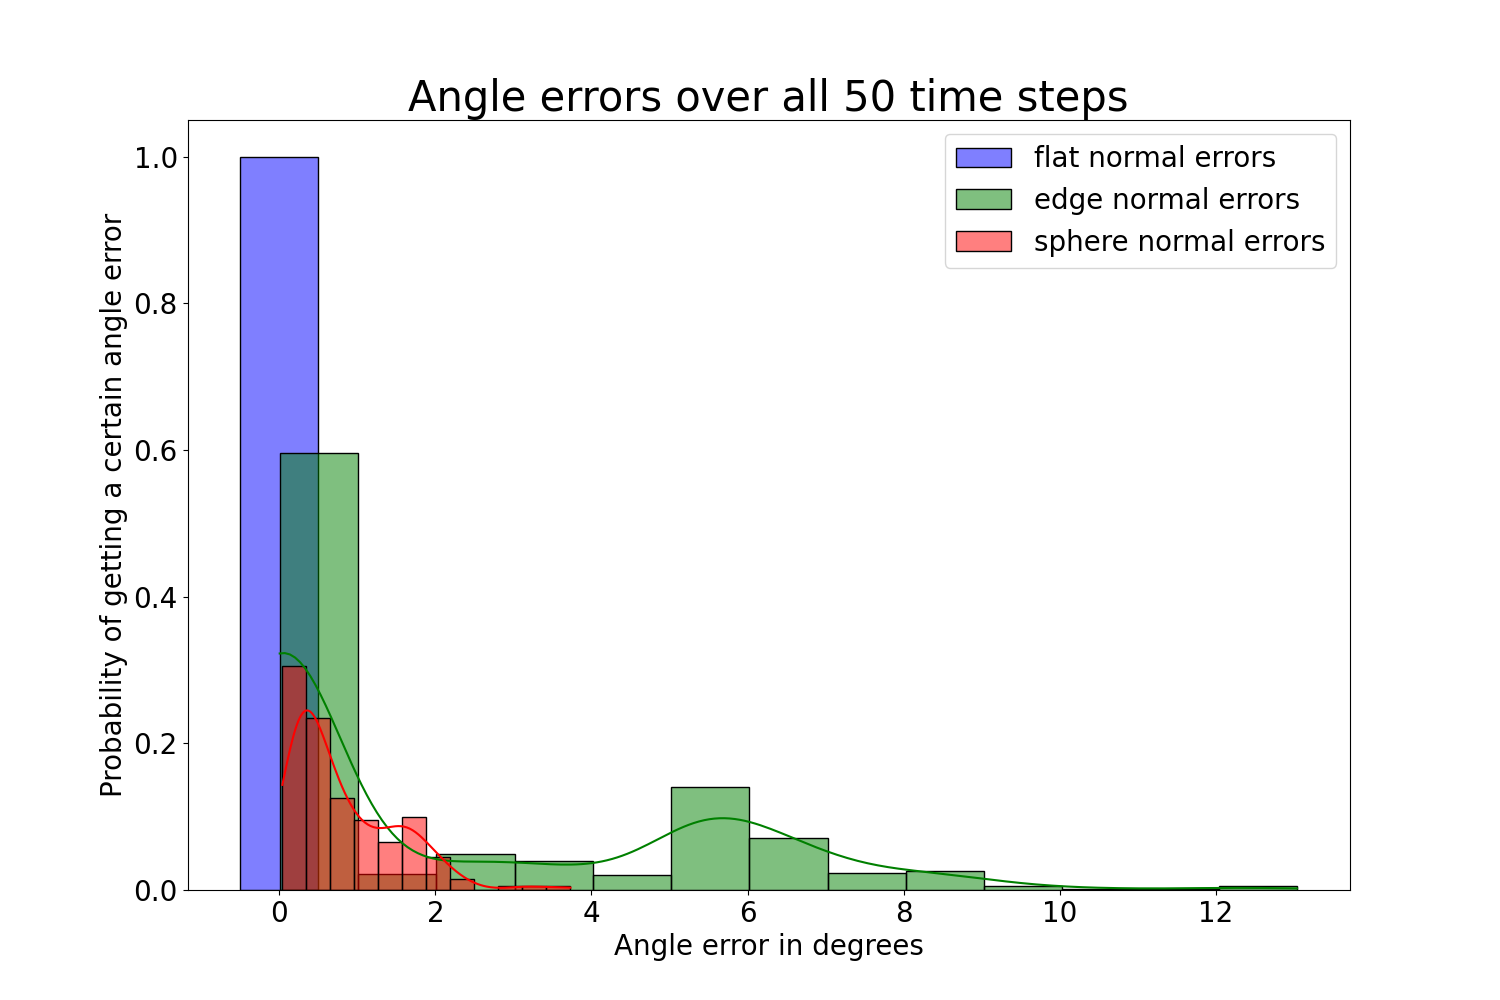

In [16]:

def get_normals(dh: DataHandler) -> List[Vector3]:
	all_normals: List[Vector3] = []
	for t in range(dh.experiment_config.num_of_dp):
		ts: DataHandler.TimeState = dh.time_states[t]
		for f in ts.fingers:
			all_normals.extend(f.normals_vec)
	return all_normals

def get_angle_errors(all_normals: List[Vector3], ref: Union[Tuple[Vector3, Vector3, Vector3],Vector3], dh: DataHandler) -> List[float]:
	# print(dh.experiment_config.prop_name)

	if dh.experiment_config.prop_name == "cube":
		return [ref.angle(n) for n in all_normals]

	elif dh.experiment_config.prop_name == "edge":
		# i = 0
		# for n in all_normals:
		# 	if abs(n.angle(Vector3(1.0,1.0,1.0))) > 45:
		# 		i += 1
		# 		print(i)
			# if min([ref[0].angle(n), ref[1].angle(n), ref[2].angle(n)]) > 20:
			# 	print(f"{ref[0]=}, {ref[1]=}, {ref[2]=}, {n=}", [ref[0].angle(n), ref[1].angle(n), ref[2].angle(n)])
		return [min([ref[0].angle(n), ref[1].angle(n), ref[2].angle(n)]) for n in all_normals]

	elif dh.experiment_config.prop_name == "sphere":
		all_sphere_normals_errors: List[float] = []
		for t in range(dhs[2].experiment_config.num_of_dp):
			sphere_ts: DataHandler.TimeState = dhs[2].time_states[t]
			for f in sphere_ts.fingers:
				for i, cp in enumerate(f.contact_points_vec):
					ref: Vector3 = cp.sub(SPHERE_CENTER).mul(-1.0)
					n: Vector3 = f.normals_vec[i]
					e = ref.angle(n)
					all_sphere_normals_errors.append(e)
		return all_sphere_normals_errors
	else:
		print("[ERROR] get_normals did not get a valid prop name, valid prop names include: cube, edge and sphere.")
		return []

def plot_errors(dh: DataHandler, ax):

	plt.title(f"Angle errors over all {dh.experiment_config.num_of_dp} time steps", fontsize=30)
 
	prop_name = dh.experiment_config.prop_name
	color = 0
	normals = get_normals(dh)
	ref = Vector3(1.0, 1.0, 1.0)
	errors = []
	if prop_name == "cube":
		ref = FLAT_REF_VEC
		errors = get_angle_errors(normals, ref, dh)
	elif prop_name == "edge":
		ref = EDGE_REF_VEC
		errors = get_angle_errors(normals, ref, dh)
		color = 1
	elif prop_name == "sphere":
		ref = SPHERE_REF_VEC
		errors = get_angle_errors(normals, ref, dh)
		color = 2
	else:
		return

	colors=["b","g","r"]

	df = pd.DataFrame({f"all_{dh.experiment_config.prop_name}_errors": errors})
	if prop_name == "cube":
		sns.histplot(data=df, ax=ax, stat="probability", label=f"flat normal errors", palette=[colors[color]])
	else:
		sns.histplot(data=df, ax=ax, stat="probability", label=f"{dh.experiment_config.prop_name} normal errors", palette=[colors[color]] ,kde=True)
	ax.tick_params(axis='both', which='major', labelsize=20)
	ax.set_xlabel("Angle error in degrees", fontsize=20)
	ax.set_ylabel("Probability of getting a certain angle error", fontsize=20)
	plt.legend(fontsize=20)

fig_his, ax_his = plt.subplots()
fig_his.set_figheight(10)
fig_his.set_figwidth(15)

for dh in dhs:
	plot_errors(dh,ax_his)
plt.savefig("fig/sr_tactile_perception_angle_errors.png")

# pull the gnc-and-adapt-master and run from github
# load in PC to matlab
# how to define the problem! - the main problem
	# external sources
	# linear problem - reverse engineer
	# FPFH

# FIX REFERENCES


